# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

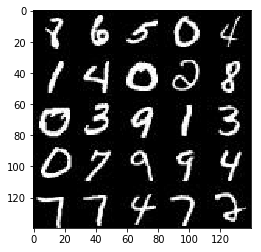

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

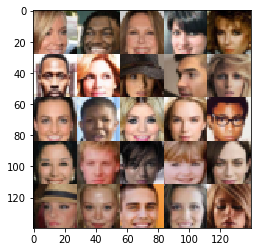

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0


/anaconda/envs/dlnd_face_gen/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [53]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image_input = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    z_data = tf.placeholder(tf.float32, shape=[None, z_dim])
    learning_rate = tf.placeholder(tf.float32, shape=[])

    return real_image_input, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [61]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        alpha = 0.01
        # images [28, 28]
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same') # [14, 14]
        leaky_relu1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d(leaky_relu1, 128, 5, strides=2, padding='same') # [7, 7]
        batch_norm2 = tf.layers.batch_normalization(layer2, training=True)
        leaky_relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        layer3 = tf.layers.conv2d(leaky_relu2, 256, 3, strides=2, padding='same') # [4, 4]
        batch_norm3 = tf.layers.batch_normalization(layer3, training=True)
        leaky_relu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        layer4 = tf.layers.conv2d(leaky_relu3, 512, 2, strides=2, padding='same') # [2, 2]
        batch_norm4 = tf.layers.batch_normalization(layer4, training=True)
        leaky_relu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        layer5 = tf.layers.conv2d(leaky_relu4, 512, 2, strides=2, padding='same') # [1, 1]
        batch_norm5 = tf.layers.batch_normalization(layer5, training=True)
        
        layer6 = tf.layers.conv2d(batch_norm5, 1, 1, strides=1, padding='same') # [1, 1]
        logit = tf.reshape(layer6, (-1, 1))
        out = tf.sigmoid(logit)
    return out, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [62]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        alpha = 0.01
        
        dense0 = tf.layers.dense(z, 1024)
        batch_norm0 = tf.layers.batch_normalization(dense0, training=is_train)
        leaky_relu0 = tf.maximum(alpha * batch_norm0, batch_norm0)
        
        dense1 = tf.layers.dense(leaky_relu0, 7*7*128)
        reshaped1 = tf.reshape(dense1, [-1, 7, 7, 128])
        batch_norm1 = tf.layers.batch_normalization(reshaped1, training=is_train)
        leaky_relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        
        layer2 = tf.layers.conv2d_transpose(leaky_relu1, 256, 5, strides=2, padding='same') # [14, 14]
        batch_norm2 = tf.layers.batch_normalization(layer2, training=is_train)
        leaky_relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        layer3 = tf.layers.conv2d_transpose(leaky_relu2, out_channel_dim, 5, strides=2, padding='same') # [28, 28]
        
        out = tf.tanh(layer3)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [63]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen = generator(input_z, out_channel_dim, is_train=True)
    out_fake, _ = discriminator(gen, reuse=False)
    out_real, _ = discriminator(input_real, reuse=True)
    
    real_labels = tf.ones_like(out_real)
    discriminator_loss = tf.reduce_mean(tf.square(real_labels - out_real) + tf.square(out_fake)) * 0.5
    
    labels_for_generator = tf.ones_like(out_fake)
    generator_loss = tf.reduce_mean(tf.square(labels_for_generator - out_fake)) * 0.5
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [64]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1)
    g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1)
    
    d_vars = tf.trainable_variables('discriminator')
    g_vars = tf.trainable_variables('generator')

    d_train_step = d_optimizer.minimize(d_loss, var_list=d_vars)
    g_train_step = g_optimizer.minimize(g_loss, var_list=g_vars)
    
    return d_train_step, g_train_step


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [66]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    real_image_input, z_data, learning_rate_tensor = model_inputs(image_width, image_height, image_channels, z_dim)
    out_channel_dim = image_channels
    discriminator_loss, generator_loss = model_loss(real_image_input, z_data, out_channel_dim)
    d_train_step, g_train_step = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    iterations = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                z_samples = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run([d_train_step],
                         feed_dict={real_image_input:batch_images,
                                    z_data:z_samples,
                                    learning_rate_tensor:learning_rate})
                
                sess.run([g_train_step],
                         feed_dict={z_data:z_samples,
                                    learning_rate_tensor:learning_rate})
                
                train_loss_d = discriminator_loss.eval({z_data:z_samples, real_image_input:batch_images})
                train_loss_g = generator_loss.eval({z_data:z_samples})
                
                iterations += 1
                
                if iterations % 20 == 0:
                    print(f'it: {iterations}, epoch {epoch_i}/{epoch_count}, d loss: {train_loss_d:.4f}, g loss: {train_loss_g:.4f}')
                
                if iterations % 100 == 0:
                    show_generator_output(sess, 16, z_data, out_channel_dim, data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

it: 20, epoch 0/2, d loss: 0.4381, g loss: 0.2812
it: 40, epoch 0/2, d loss: 0.3128, g loss: 0.3102
it: 60, epoch 0/2, d loss: 0.4204, g loss: 0.1909
it: 80, epoch 0/2, d loss: 0.3908, g loss: 0.2214
it: 100, epoch 0/2, d loss: 0.4251, g loss: 0.1576


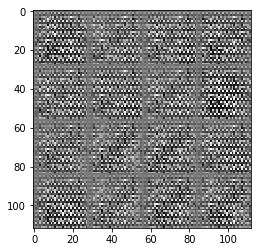

it: 120, epoch 0/2, d loss: 0.3625, g loss: 0.2114
it: 140, epoch 0/2, d loss: 0.3305, g loss: 0.2144
it: 160, epoch 0/2, d loss: 0.2902, g loss: 0.3146
it: 180, epoch 0/2, d loss: 0.2801, g loss: 0.3088
it: 200, epoch 0/2, d loss: 0.3060, g loss: 0.2492


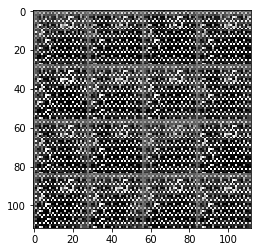

it: 220, epoch 0/2, d loss: 0.3570, g loss: 0.2275
it: 240, epoch 0/2, d loss: 0.3562, g loss: 0.1916
it: 260, epoch 0/2, d loss: 0.1648, g loss: 0.2596
it: 280, epoch 0/2, d loss: 0.2895, g loss: 0.3235
it: 300, epoch 0/2, d loss: 0.0757, g loss: 0.3647


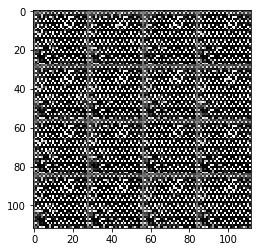

it: 320, epoch 0/2, d loss: 0.2105, g loss: 0.3894
it: 340, epoch 0/2, d loss: 0.0680, g loss: 0.4074
it: 360, epoch 0/2, d loss: 0.1304, g loss: 0.3189
it: 380, epoch 0/2, d loss: 0.3869, g loss: 0.3126
it: 400, epoch 0/2, d loss: 0.1262, g loss: 0.3550


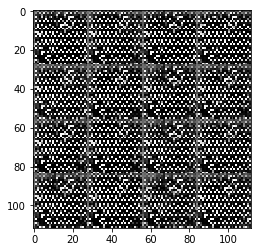

it: 420, epoch 0/2, d loss: 0.1280, g loss: 0.4103
it: 440, epoch 0/2, d loss: 0.0934, g loss: 0.3914
it: 460, epoch 0/2, d loss: 0.0987, g loss: 0.4462
it: 480, epoch 0/2, d loss: 0.0637, g loss: 0.4576
it: 500, epoch 0/2, d loss: 0.1060, g loss: 0.3906


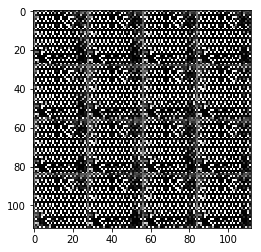

it: 520, epoch 0/2, d loss: 0.0945, g loss: 0.4662
it: 540, epoch 0/2, d loss: 0.0666, g loss: 0.4443
it: 560, epoch 0/2, d loss: 0.1115, g loss: 0.4567
it: 580, epoch 0/2, d loss: 0.0666, g loss: 0.4531
it: 600, epoch 0/2, d loss: 0.0946, g loss: 0.4612


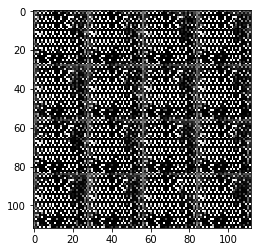

it: 620, epoch 0/2, d loss: 0.1264, g loss: 0.4554
it: 640, epoch 0/2, d loss: 0.0902, g loss: 0.3773
it: 660, epoch 0/2, d loss: 0.0859, g loss: 0.4606
it: 680, epoch 0/2, d loss: 0.0951, g loss: 0.4565
it: 700, epoch 0/2, d loss: 0.0979, g loss: 0.4375


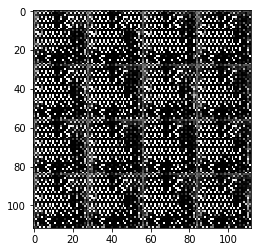

it: 720, epoch 0/2, d loss: 0.0663, g loss: 0.4491
it: 740, epoch 0/2, d loss: 0.0648, g loss: 0.4433
it: 760, epoch 0/2, d loss: 0.0962, g loss: 0.4450
it: 780, epoch 0/2, d loss: 0.0340, g loss: 0.4539
it: 800, epoch 0/2, d loss: 0.1181, g loss: 0.3821


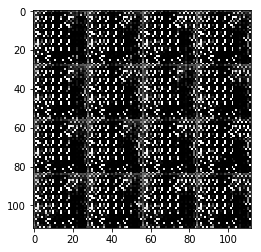

it: 820, epoch 0/2, d loss: 0.0652, g loss: 0.4653
it: 840, epoch 0/2, d loss: 0.0952, g loss: 0.4592
it: 860, epoch 0/2, d loss: 0.2694, g loss: 0.3939
it: 880, epoch 0/2, d loss: 0.1442, g loss: 0.3792
it: 900, epoch 0/2, d loss: 0.1264, g loss: 0.4026


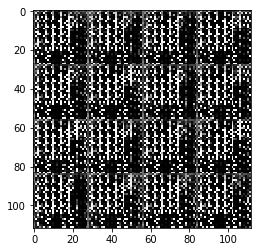

it: 920, epoch 0/2, d loss: 0.1267, g loss: 0.4520
it: 940, epoch 0/2, d loss: 0.1456, g loss: 0.4558
it: 960, epoch 0/2, d loss: 0.1367, g loss: 0.4320
it: 980, epoch 0/2, d loss: 0.0362, g loss: 0.4390
it: 1000, epoch 0/2, d loss: 0.0940, g loss: 0.4418


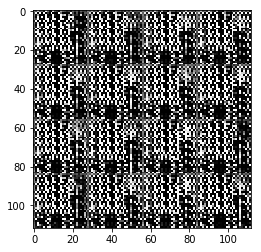

it: 1020, epoch 0/2, d loss: 0.1620, g loss: 0.4273
it: 1040, epoch 0/2, d loss: 0.0395, g loss: 0.4649
it: 1060, epoch 0/2, d loss: 0.0338, g loss: 0.4608
it: 1080, epoch 0/2, d loss: 0.0660, g loss: 0.4484
it: 1100, epoch 0/2, d loss: 0.0414, g loss: 0.4403


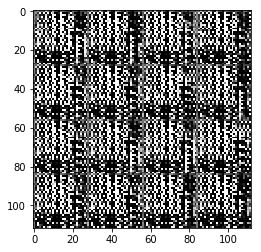

it: 1120, epoch 0/2, d loss: 0.0985, g loss: 0.4436
it: 1140, epoch 0/2, d loss: 0.0636, g loss: 0.4613
it: 1160, epoch 0/2, d loss: 0.0394, g loss: 0.4621
it: 1180, epoch 0/2, d loss: 0.0897, g loss: 0.3894
it: 1200, epoch 0/2, d loss: 0.0947, g loss: 0.4662


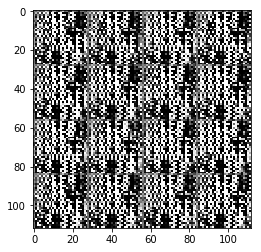

it: 1220, epoch 0/2, d loss: 0.0357, g loss: 0.4600
it: 1240, epoch 0/2, d loss: 0.0629, g loss: 0.4827
it: 1260, epoch 0/2, d loss: 0.0965, g loss: 0.4676
it: 1280, epoch 0/2, d loss: 0.1568, g loss: 0.4820
it: 1300, epoch 0/2, d loss: 0.0633, g loss: 0.4744


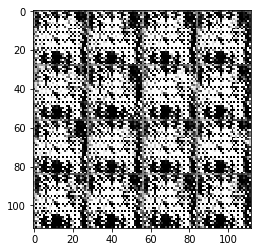

it: 1320, epoch 0/2, d loss: 0.0674, g loss: 0.4531
it: 1340, epoch 0/2, d loss: 0.1112, g loss: 0.3734
it: 1360, epoch 0/2, d loss: 0.0949, g loss: 0.4672
it: 1380, epoch 0/2, d loss: 0.0630, g loss: 0.4764
it: 1400, epoch 0/2, d loss: 0.0948, g loss: 0.4788


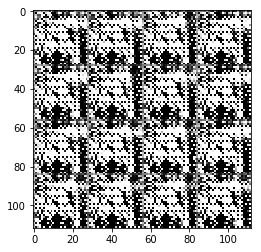

it: 1420, epoch 0/2, d loss: 0.1692, g loss: 0.3451
it: 1440, epoch 0/2, d loss: 0.2354, g loss: 0.3100
it: 1460, epoch 0/2, d loss: 0.0957, g loss: 0.4660
it: 1480, epoch 0/2, d loss: 0.1273, g loss: 0.4531
it: 1500, epoch 0/2, d loss: 0.0729, g loss: 0.4471


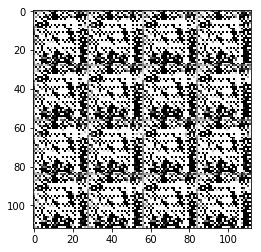

it: 1520, epoch 0/2, d loss: 0.0330, g loss: 0.4761
it: 1540, epoch 0/2, d loss: 0.0382, g loss: 0.4329
it: 1560, epoch 0/2, d loss: 0.0651, g loss: 0.4563
it: 1580, epoch 0/2, d loss: 0.0729, g loss: 0.4460
it: 1600, epoch 0/2, d loss: 0.3229, g loss: 0.3959


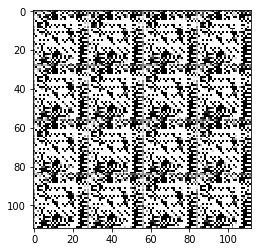

it: 1620, epoch 0/2, d loss: 0.1274, g loss: 0.4595
it: 1640, epoch 0/2, d loss: 0.0630, g loss: 0.4767
it: 1660, epoch 0/2, d loss: 0.1259, g loss: 0.4713
it: 1680, epoch 0/2, d loss: 0.1314, g loss: 0.4763
it: 1700, epoch 0/2, d loss: 0.0644, g loss: 0.4600


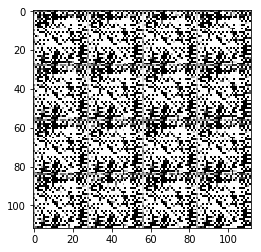

it: 1720, epoch 0/2, d loss: 0.0940, g loss: 0.4736
it: 1740, epoch 0/2, d loss: 0.0948, g loss: 0.4667
it: 1760, epoch 0/2, d loss: 0.0663, g loss: 0.4567
it: 1780, epoch 0/2, d loss: 0.0640, g loss: 0.4631
it: 1800, epoch 0/2, d loss: 0.0404, g loss: 0.4671


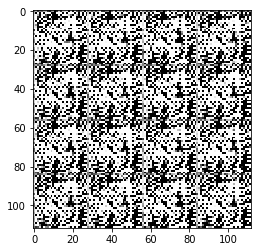

it: 1820, epoch 0/2, d loss: 0.0690, g loss: 0.4504
it: 1840, epoch 0/2, d loss: 0.0348, g loss: 0.4676
it: 1860, epoch 0/2, d loss: 0.1471, g loss: 0.4055
it: 1880, epoch 0/2, d loss: 0.1211, g loss: 0.4372
it: 1900, epoch 0/2, d loss: 0.1643, g loss: 0.3857


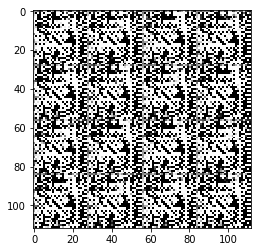

it: 1920, epoch 0/2, d loss: 0.0645, g loss: 0.4685
it: 1940, epoch 0/2, d loss: 0.0957, g loss: 0.4637
it: 1960, epoch 0/2, d loss: 0.0334, g loss: 0.4685
it: 1980, epoch 0/2, d loss: 0.0628, g loss: 0.4796
it: 2000, epoch 0/2, d loss: 0.0637, g loss: 0.4672


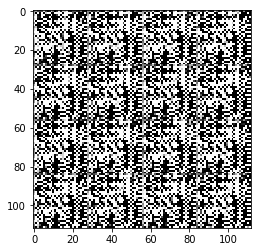

it: 2020, epoch 0/2, d loss: 0.0945, g loss: 0.4698
it: 2040, epoch 0/2, d loss: 0.1264, g loss: 0.4618
it: 2060, epoch 0/2, d loss: 0.1311, g loss: 0.4392
it: 2080, epoch 0/2, d loss: 0.0997, g loss: 0.4451
it: 2100, epoch 0/2, d loss: 0.0352, g loss: 0.4554


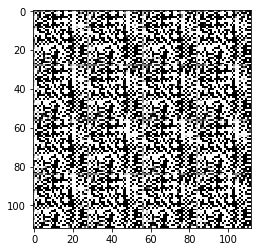

it: 2120, epoch 0/2, d loss: 0.0722, g loss: 0.4177
it: 2140, epoch 0/2, d loss: 0.1141, g loss: 0.4707
it: 2160, epoch 0/2, d loss: 0.0835, g loss: 0.4354
it: 2180, epoch 0/2, d loss: 0.0639, g loss: 0.4633
it: 2200, epoch 0/2, d loss: 0.1071, g loss: 0.4172


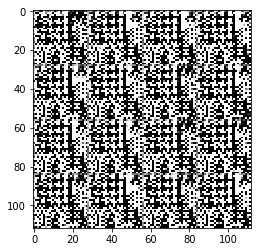

it: 2220, epoch 0/2, d loss: 0.0962, g loss: 0.4555
it: 2240, epoch 0/2, d loss: 0.0635, g loss: 0.4652
it: 2260, epoch 0/2, d loss: 0.0324, g loss: 0.4697
it: 2280, epoch 0/2, d loss: 0.0633, g loss: 0.4677
it: 2300, epoch 0/2, d loss: 0.0889, g loss: 0.4306


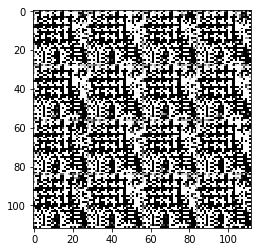

it: 2320, epoch 0/2, d loss: 0.0947, g loss: 0.4677
it: 2340, epoch 0/2, d loss: 0.0390, g loss: 0.4362
it: 2360, epoch 0/2, d loss: 0.0328, g loss: 0.4822
it: 2380, epoch 0/2, d loss: 0.0351, g loss: 0.4656
it: 2400, epoch 0/2, d loss: 0.0717, g loss: 0.4241


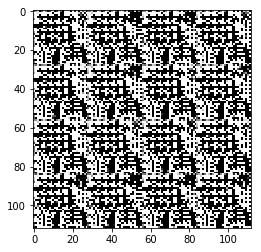

it: 2420, epoch 0/2, d loss: 0.0628, g loss: 0.4809
it: 2440, epoch 0/2, d loss: 0.0946, g loss: 0.4738
it: 2460, epoch 0/2, d loss: 0.0631, g loss: 0.4733
it: 2480, epoch 0/2, d loss: 0.0346, g loss: 0.4517
it: 2500, epoch 0/2, d loss: 0.0328, g loss: 0.4655


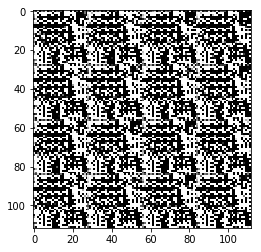

it: 2520, epoch 0/2, d loss: 0.0633, g loss: 0.4700
it: 2540, epoch 0/2, d loss: 0.0628, g loss: 0.4795
it: 2560, epoch 0/2, d loss: 0.0633, g loss: 0.4750
it: 2580, epoch 0/2, d loss: 0.0629, g loss: 0.4774
it: 2600, epoch 0/2, d loss: 0.0650, g loss: 0.4582


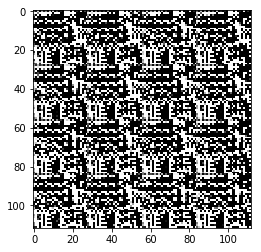

it: 2620, epoch 0/2, d loss: 0.0663, g loss: 0.4530
it: 2640, epoch 0/2, d loss: 0.0338, g loss: 0.4672
it: 2660, epoch 0/2, d loss: 0.1085, g loss: 0.4461
it: 2680, epoch 0/2, d loss: 0.1565, g loss: 0.4846
it: 2700, epoch 0/2, d loss: 0.1292, g loss: 0.4680


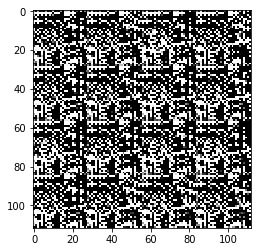

it: 2720, epoch 0/2, d loss: 0.0579, g loss: 0.4301
it: 2740, epoch 0/2, d loss: 0.0627, g loss: 0.4877
it: 2760, epoch 0/2, d loss: 0.0691, g loss: 0.4485
it: 2780, epoch 0/2, d loss: 0.0639, g loss: 0.4646
it: 2800, epoch 0/2, d loss: 0.0629, g loss: 0.4811


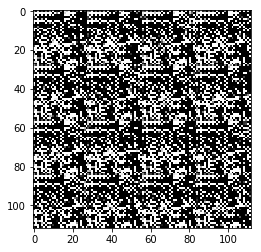

it: 2820, epoch 0/2, d loss: 0.0945, g loss: 0.4750
it: 2840, epoch 0/2, d loss: 0.0939, g loss: 0.4871
it: 2860, epoch 0/2, d loss: 0.0945, g loss: 0.4783
it: 2880, epoch 0/2, d loss: 0.0475, g loss: 0.4474
it: 2900, epoch 0/2, d loss: 0.0324, g loss: 0.4748


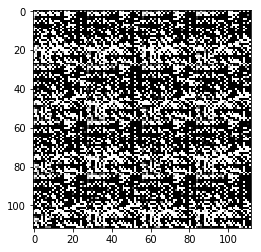

it: 2920, epoch 0/2, d loss: 0.0635, g loss: 0.4698
it: 2940, epoch 0/2, d loss: 0.0948, g loss: 0.4664
it: 2960, epoch 0/2, d loss: 0.0648, g loss: 0.4574
it: 2980, epoch 0/2, d loss: 0.0633, g loss: 0.4705
it: 3000, epoch 0/2, d loss: 0.2018, g loss: 0.4404


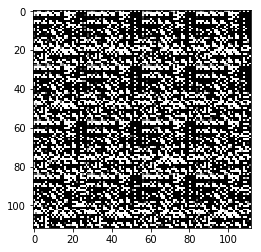

it: 3020, epoch 0/2, d loss: 0.0318, g loss: 0.4759
it: 3040, epoch 0/2, d loss: 0.0317, g loss: 0.4759
it: 3060, epoch 0/2, d loss: 0.0948, g loss: 0.4713
it: 3080, epoch 0/2, d loss: 0.0644, g loss: 0.4703
it: 3100, epoch 0/2, d loss: 0.0628, g loss: 0.4796


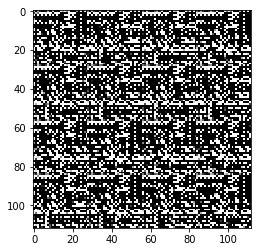

it: 3120, epoch 0/2, d loss: 0.0316, g loss: 0.4793
it: 3140, epoch 0/2, d loss: 0.0320, g loss: 0.4764
it: 3160, epoch 0/2, d loss: 0.0649, g loss: 0.4537
it: 3180, epoch 0/2, d loss: 0.0636, g loss: 0.4743
it: 3200, epoch 0/2, d loss: 0.0639, g loss: 0.4655


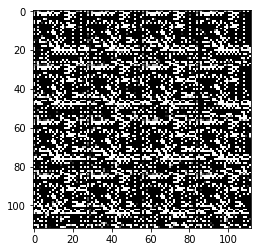

it: 3220, epoch 0/2, d loss: 0.0743, g loss: 0.4528
it: 3240, epoch 0/2, d loss: 0.0626, g loss: 0.4893
it: 3260, epoch 0/2, d loss: 0.0631, g loss: 0.4797
it: 3280, epoch 0/2, d loss: 0.1290, g loss: 0.4062
it: 3300, epoch 0/2, d loss: 0.0631, g loss: 0.4833


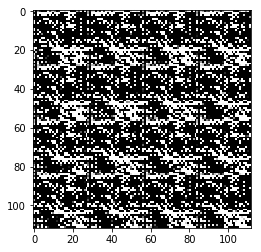

it: 3320, epoch 0/2, d loss: 0.0634, g loss: 0.4752
it: 3340, epoch 0/2, d loss: 0.0626, g loss: 0.4917
it: 3360, epoch 0/2, d loss: 0.0634, g loss: 0.4765
it: 3380, epoch 0/2, d loss: 0.0630, g loss: 0.4818
it: 3400, epoch 0/2, d loss: 0.0629, g loss: 0.4892


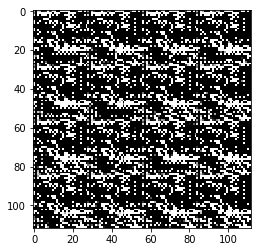

it: 3420, epoch 0/2, d loss: 0.0420, g loss: 0.4402
it: 3440, epoch 0/2, d loss: 0.0637, g loss: 0.4657
it: 3460, epoch 0/2, d loss: 0.0645, g loss: 0.4621
it: 3480, epoch 0/2, d loss: 0.0945, g loss: 0.4741
it: 3500, epoch 0/2, d loss: 0.0959, g loss: 0.4570


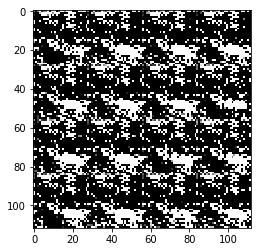

it: 3520, epoch 0/2, d loss: 0.1268, g loss: 0.4619
it: 3540, epoch 0/2, d loss: 0.0945, g loss: 0.4784
it: 3560, epoch 0/2, d loss: 0.0647, g loss: 0.4625
it: 3580, epoch 0/2, d loss: 0.0631, g loss: 0.4734
it: 3600, epoch 0/2, d loss: 0.0339, g loss: 0.4566


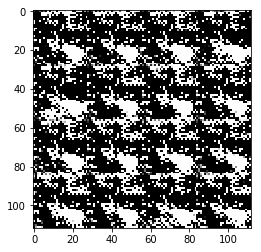

it: 3620, epoch 0/2, d loss: 0.1270, g loss: 0.3692
it: 3640, epoch 0/2, d loss: 0.0642, g loss: 0.4688
it: 3660, epoch 0/2, d loss: 0.0633, g loss: 0.4803
it: 3680, epoch 0/2, d loss: 0.0448, g loss: 0.4476
it: 3700, epoch 0/2, d loss: 0.0314, g loss: 0.4906


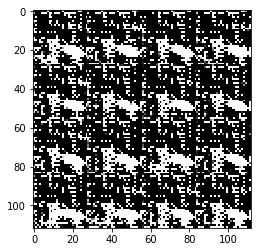

it: 3720, epoch 0/2, d loss: 0.0679, g loss: 0.4717
it: 3740, epoch 0/2, d loss: 0.0941, g loss: 0.4832
it: 3760, epoch 1/2, d loss: 0.0315, g loss: 0.4907
it: 3780, epoch 1/2, d loss: 0.1062, g loss: 0.4823
it: 3800, epoch 1/2, d loss: 0.1279, g loss: 0.4738


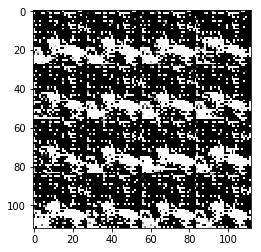

it: 3820, epoch 1/2, d loss: 0.0625, g loss: 0.4919
it: 3840, epoch 1/2, d loss: 0.0771, g loss: 0.4859
it: 3860, epoch 1/2, d loss: 0.1047, g loss: 0.4431
it: 3880, epoch 1/2, d loss: 0.0941, g loss: 0.4840
it: 3900, epoch 1/2, d loss: 0.0632, g loss: 0.4809


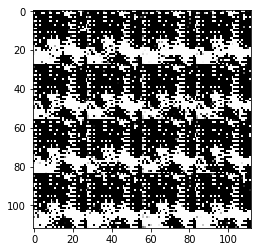

it: 3920, epoch 1/2, d loss: 0.1252, g loss: 0.4899
it: 3940, epoch 1/2, d loss: 0.0940, g loss: 0.4884
it: 3960, epoch 1/2, d loss: 0.0642, g loss: 0.4755
it: 3980, epoch 1/2, d loss: 0.0629, g loss: 0.4817
it: 4000, epoch 1/2, d loss: 0.0628, g loss: 0.4880


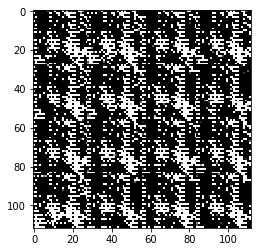

it: 4020, epoch 1/2, d loss: 0.0629, g loss: 0.4860
it: 4040, epoch 1/2, d loss: 0.0332, g loss: 0.4711
it: 4060, epoch 1/2, d loss: 0.0939, g loss: 0.4875
it: 4080, epoch 1/2, d loss: 0.0697, g loss: 0.4436
it: 4100, epoch 1/2, d loss: 0.0628, g loss: 0.4881


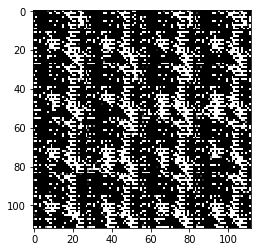

it: 4120, epoch 1/2, d loss: 0.0710, g loss: 0.4854
it: 4140, epoch 1/2, d loss: 0.0942, g loss: 0.4801
it: 4160, epoch 1/2, d loss: 0.0322, g loss: 0.4731
it: 4180, epoch 1/2, d loss: 0.0446, g loss: 0.4319
it: 4200, epoch 1/2, d loss: 0.0625, g loss: 0.4751


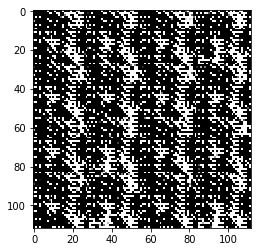

it: 4220, epoch 1/2, d loss: 0.0959, g loss: 0.4664
it: 4240, epoch 1/2, d loss: 0.0319, g loss: 0.4743
it: 4260, epoch 1/2, d loss: 0.0316, g loss: 0.4831
it: 4280, epoch 1/2, d loss: 0.0325, g loss: 0.4810
it: 4300, epoch 1/2, d loss: 0.0390, g loss: 0.4500


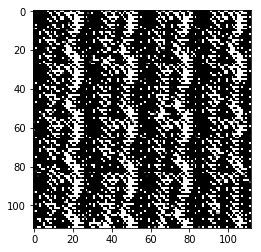

it: 4320, epoch 1/2, d loss: 0.0628, g loss: 0.4833
it: 4340, epoch 1/2, d loss: 0.0373, g loss: 0.4666
it: 4360, epoch 1/2, d loss: 0.0340, g loss: 0.4725
it: 4380, epoch 1/2, d loss: 0.0940, g loss: 0.4888
it: 4400, epoch 1/2, d loss: 0.0657, g loss: 0.4614


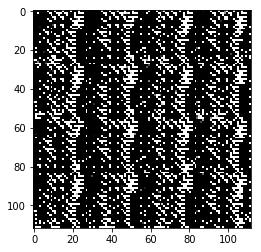

it: 4420, epoch 1/2, d loss: 0.1004, g loss: 0.4540
it: 4440, epoch 1/2, d loss: 0.0627, g loss: 0.4892
it: 4460, epoch 1/2, d loss: 0.0336, g loss: 0.4750
it: 4480, epoch 1/2, d loss: 0.0641, g loss: 0.4731
it: 4500, epoch 1/2, d loss: 0.0944, g loss: 0.4745


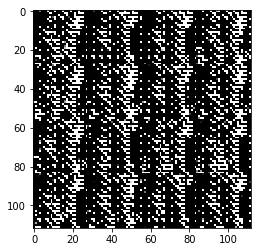

it: 4520, epoch 1/2, d loss: 0.0682, g loss: 0.4798
it: 4540, epoch 1/2, d loss: 0.0629, g loss: 0.4808
it: 4560, epoch 1/2, d loss: 0.0326, g loss: 0.4791
it: 4580, epoch 1/2, d loss: 0.0315, g loss: 0.4860
it: 4600, epoch 1/2, d loss: 0.0931, g loss: 0.4863


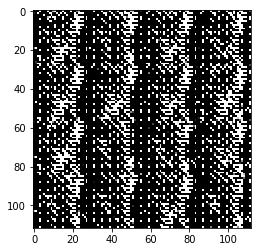

it: 4620, epoch 1/2, d loss: 0.1883, g loss: 0.4715
it: 4640, epoch 1/2, d loss: 0.0321, g loss: 0.4730
it: 4660, epoch 1/2, d loss: 0.0660, g loss: 0.4591
it: 4680, epoch 1/2, d loss: 0.0629, g loss: 0.4791
it: 4700, epoch 1/2, d loss: 0.0634, g loss: 0.4678


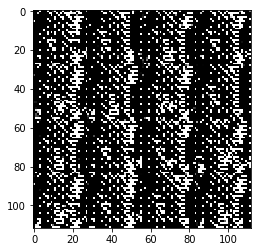

it: 4720, epoch 1/2, d loss: 0.0964, g loss: 0.4558
it: 4740, epoch 1/2, d loss: 0.0326, g loss: 0.4802
it: 4760, epoch 1/2, d loss: 0.0317, g loss: 0.4937
it: 4780, epoch 1/2, d loss: 0.0631, g loss: 0.4753
it: 4800, epoch 1/2, d loss: 0.0628, g loss: 0.4848


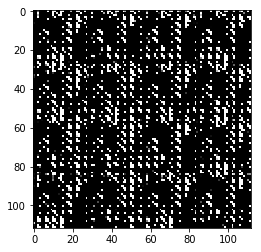

it: 4820, epoch 1/2, d loss: 0.0701, g loss: 0.4403
it: 4840, epoch 1/2, d loss: 0.0946, g loss: 0.4829
it: 4860, epoch 1/2, d loss: 0.0635, g loss: 0.4758
it: 4880, epoch 1/2, d loss: 0.0633, g loss: 0.4699
it: 4900, epoch 1/2, d loss: 0.0627, g loss: 0.4861


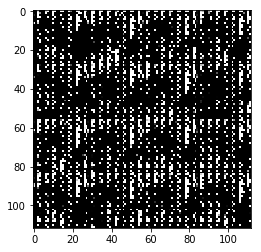

it: 4920, epoch 1/2, d loss: 0.0631, g loss: 0.4847
it: 4940, epoch 1/2, d loss: 0.0338, g loss: 0.4751
it: 4960, epoch 1/2, d loss: 0.0317, g loss: 0.4889
it: 4980, epoch 1/2, d loss: 0.0375, g loss: 0.4534
it: 5000, epoch 1/2, d loss: 0.0370, g loss: 0.4598


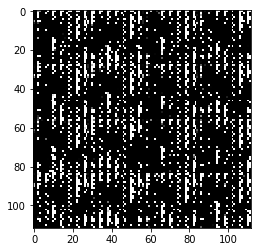

it: 5020, epoch 1/2, d loss: 0.0629, g loss: 0.4814
it: 5040, epoch 1/2, d loss: 0.1391, g loss: 0.3504
it: 5060, epoch 1/2, d loss: 0.0954, g loss: 0.4701
it: 5080, epoch 1/2, d loss: 0.0943, g loss: 0.4754
it: 5100, epoch 1/2, d loss: 0.0639, g loss: 0.4605


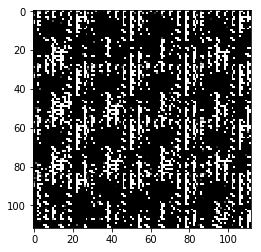

it: 5120, epoch 1/2, d loss: 0.0651, g loss: 0.4647
it: 5140, epoch 1/2, d loss: 0.1638, g loss: 0.3864
it: 5160, epoch 1/2, d loss: 0.0942, g loss: 0.4787
it: 5180, epoch 1/2, d loss: 0.0322, g loss: 0.4687
it: 5200, epoch 1/2, d loss: 0.0337, g loss: 0.4568


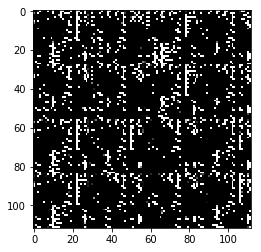

it: 5220, epoch 1/2, d loss: 0.0669, g loss: 0.4500
it: 5240, epoch 1/2, d loss: 0.0626, g loss: 0.4864
it: 5260, epoch 1/2, d loss: 0.0779, g loss: 0.4364
it: 5280, epoch 1/2, d loss: 0.0331, g loss: 0.4785
it: 5300, epoch 1/2, d loss: 0.0684, g loss: 0.4516


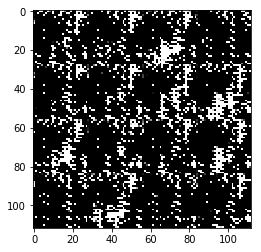

it: 5320, epoch 1/2, d loss: 0.1000, g loss: 0.4562
it: 5340, epoch 1/2, d loss: 0.0978, g loss: 0.4381
it: 5360, epoch 1/2, d loss: 0.2312, g loss: 0.4510
it: 5380, epoch 1/2, d loss: 0.0630, g loss: 0.4832
it: 5400, epoch 1/2, d loss: 0.0655, g loss: 0.4696


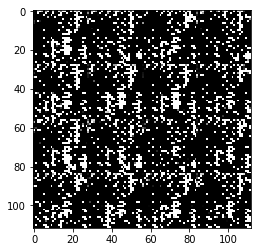

it: 5420, epoch 1/2, d loss: 0.0662, g loss: 0.4525
it: 5440, epoch 1/2, d loss: 0.0626, g loss: 0.4889
it: 5460, epoch 1/2, d loss: 0.0635, g loss: 0.4787
it: 5480, epoch 1/2, d loss: 0.0320, g loss: 0.4744
it: 5500, epoch 1/2, d loss: 0.1422, g loss: 0.4698


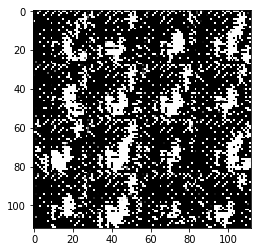

it: 5520, epoch 1/2, d loss: 0.0630, g loss: 0.4886
it: 5540, epoch 1/2, d loss: 0.0983, g loss: 0.4108
it: 5560, epoch 1/2, d loss: 0.1563, g loss: 0.4947
it: 5580, epoch 1/2, d loss: 0.0946, g loss: 0.4829
it: 5600, epoch 1/2, d loss: 0.0324, g loss: 0.4877


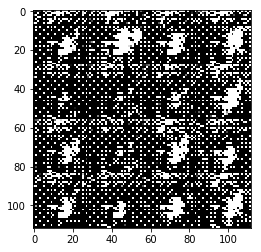

it: 5620, epoch 1/2, d loss: 0.0943, g loss: 0.4790
it: 5640, epoch 1/2, d loss: 0.0771, g loss: 0.4373
it: 5660, epoch 1/2, d loss: 0.1061, g loss: 0.3910
it: 5680, epoch 1/2, d loss: 0.0951, g loss: 0.4821
it: 5700, epoch 1/2, d loss: 0.0544, g loss: 0.4037


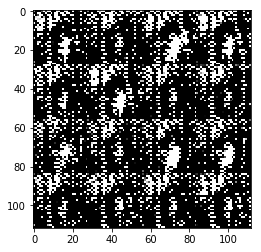

it: 5720, epoch 1/2, d loss: 0.0320, g loss: 0.4946
it: 5740, epoch 1/2, d loss: 0.0419, g loss: 0.4669
it: 5760, epoch 1/2, d loss: 0.1184, g loss: 0.3757
it: 5780, epoch 1/2, d loss: 0.4314, g loss: 0.0812
it: 5800, epoch 1/2, d loss: 0.1134, g loss: 0.4562


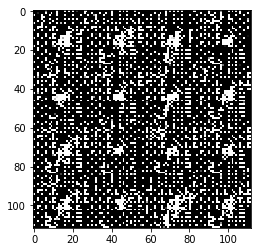

it: 5820, epoch 1/2, d loss: 0.0626, g loss: 0.4924
it: 5840, epoch 1/2, d loss: 0.0940, g loss: 0.4873
it: 5860, epoch 1/2, d loss: 0.0942, g loss: 0.4853
it: 5880, epoch 1/2, d loss: 0.1572, g loss: 0.4832
it: 5900, epoch 1/2, d loss: 0.0989, g loss: 0.4574


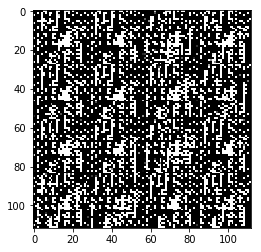

In [ ]:
batch_size = 16
z_dim = 96
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.